In [1]:
import numpy as np
import matplotlib.pyplot as plt 

import yaml

from Qatmosphere_2d import Atmsophere

%matplotlib inline

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


In [2]:
with open('/home/laclavere/Documents/Thesis/qubic/qubic/scripts/Atmosphere/params.yml', 'r') as file:
    params = yaml.safe_load(file)

In [3]:
atm = Atmsophere(params)

In [4]:
rho = atm.mean_water_vapor_density
print(rho)

2.8533077867727576


In [5]:
delta_rho = atm.generate_spatial_fluctuations_2d()
print(type(delta_rho))

<class 'numpy.ndarray'>


In [6]:
atm.get_water_vapor_density_2d_map()

array([[2.85654109, 2.84969442, 2.84864876, ..., 2.85539917, 2.85776859,
        2.85826084],
       [2.85496098, 2.84955086, 2.84668169, ..., 2.85845346, 2.86451353,
        2.85944797],
       [2.85505619, 2.85106002, 2.84876534, ..., 2.8597608 , 2.86418499,
        2.85886697],
       ...,
       [2.84730932, 2.84778701, 2.84937543, ..., 2.85445629, 2.85162866,
        2.84841841],
       [2.84595721, 2.84656292, 2.85045673, ..., 2.8545219 , 2.85392285,
        2.8504885 ],
       [2.84929388, 2.84785502, 2.84739369, ..., 2.85581654, 2.85714983,
        2.85464892]])

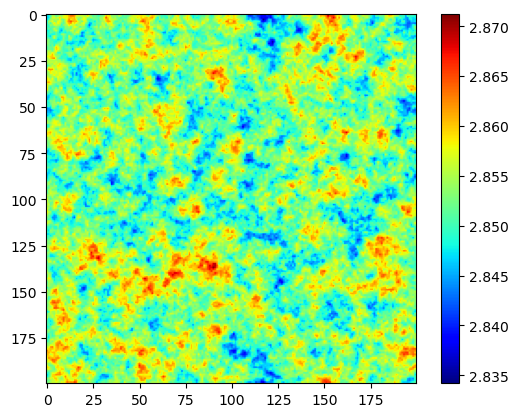

In [7]:
plt.imshow(atm.get_water_vapor_density_2d_map(), cmap='jet')
plt.colorbar()

In [8]:
map_temp = atm.water_vapor_density_to_detector_temperature()
frequencies = atm.integrated_absorption_spectrum()[1]

In [9]:
fig, axs = plt.subplots(len(frequencies), 1, figsize=(10, 5*len(frequencies)))
for i in range(len(frequencies)):
    im = axs[i].imshow(map_temp[i])
    plt.colorbar(im, ax=axs[i])
    axs[i].set_title(f'Frequency: {frequencies[i]} GHz')
plt.tight_layout()
plt.show()

TypeError: object of type 'int' has no len()

In [3]:
from astropy import units as u
from astropy.cosmology import Planck18 as cosmo

In [4]:
freq1 = 130 * u.GHz
freq2 = 270 * u.GHz
equiv1 = u.thermodynamic_temperature(freq1, cosmo.Tcmb0)
equiv2 = u.thermodynamic_temperature(freq2, cosmo.Tcmb0)

In [9]:
print(cosmo.Tcmb0.value)

2.7255
